# Calculation of Free Energy of Two Basins of the Muller-Brown Potential

In [1]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import torch
torch.set_default_dtype(torch.double)
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from sys import exit
import pickle
import scipy.integrate as integrate
import os

## Definitions and Potential Energy Contour Plot

The function, $\text{compute\_Muller\_potential(beta, x)}$ take in a constant $\beta = k_BT$ and a two dimensional coordinate $x = (x_1, x_2)$ and returns the potential energy at that point. Below we plot a contour plot of the potential energy surface. 

In [2]:
def compute_Muller_potential(beta, x):
    A = (-200., -100., -170., 15.)
    b = (0., 0., 11., 0.6)    
    ac = (x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-6.5, -6.5]),
          x.new_tensor([0.7, 0.7]))
    
    x0 = (x.new_tensor([ 1.0, 0.0]),
          x.new_tensor([ 0.0, 0.5]),
          x.new_tensor([-0.5, 1.5]),
          x.new_tensor([-1.0, 1.0]))
    
    U = 0    
    for i in range(4):
        diff = x - x0[i]
        U = U + A[i]*torch.exp(torch.sum(ac[i]*diff**2, -1) + b[i]*torch.prod(diff, -1))

    return beta*U

def generate_grid(x1_min, x1_max, x2_min, x2_max, ndim1, ndim2):
    x1 = torch.linspace(x1_min, x1_max, steps=ndim1)
    x2 = torch.linspace(x2_min, x2_max, steps=ndim2)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2)
    grid = torch.stack([grid_x1, grid_x2], dim = -1)
    x = grid.reshape((-1, 2))
    return x
    
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0
ndim = 100

x = generate_grid(x1_min, x1_max, x2_min, x2_max, ndim, ndim)
U = compute_Muller_potential(1, x)
U = U.reshape(ndim, ndim)
U = U.T

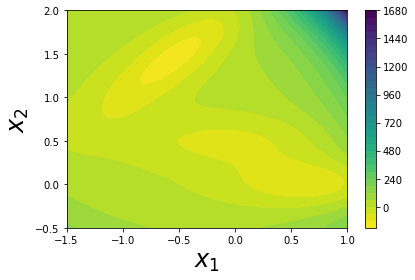

In [3]:
fig = plt.figure(0)
fig.clf()
plt.contourf(U, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
#plt.contourf(U, levels = 30, cmap = cm.viridis_r)
plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.colorbar()
plt.tight_layout()

In [4]:
def compute_Muller_potential_point(beta, r):
    """
    Computes the Muller potential at a point r = (x, y).
    """
    x = r[0]
    y = r[1]
    A = (-200., -100., -170., 15.)
    a = (-1, -1, -6.5, 0.7)
    b = (0., 0., 11., 0.6) 
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)

    result = 0
    for k in range(4):
        result += A[k]*np.exp(a[k]*(x-x0[k])**2 + b[k]*(x-x0[k])*(y-y0[k])+ c[k]*(y-y0[k])**2)
    return beta*result 

In [6]:
partition_function = dict()
beta = 0.05
def p_x_y(x, y, beta = 0.05):
    """
    Returns the probability density at a point (x, y).
    """
    b_U_r = compute_Muller_potential_point(beta, (x, y))
    try:
        q = partition_function[beta]
    except:
        q = integrate.nquad(lambda x, y: np.exp(-compute_Muller_potential_point(beta, (x , y))), 
        [[-1.5, 1], [-0.5, 2]])
        partition_function[beta] = q
    
    return np.exp(-b_U_r)/q[0]

basin1_q = integrate.nquad(p_x_y, [[-1.5, 0], [0.55, 2]])
basin2_q = integrate.nquad(p_x_y, [[-0.8, 1], [-0.5, 0.8]])

print(-np.log(basin1_q[0]/basin2_q[0]))
print(-np.log(basin2_q[0]/basin1_q[0]))
print(-(1/beta)*np.log(basin1_q[0]/basin2_q[0]))

-1.4440260764436557
1.4440260764436557
-28.880521528873114


### Self-test

We make sure that the two functions give the same energy for a point. 

In [7]:
print(compute_Muller_potential(0.05, torch.tensor((0.75, 0.75))))
print(compute_Muller_potential_point(0.05, torch.tensor((0.75, 0.75))))

tensor(3.5826)
tensor(3.5826)


# Compute Free Energy Difference by Direct Counting From TREMC

In [9]:
'''d = os.path.abspath('')
with open('x_record_alpha_{:.3f}.pkl'.format(beta), 'rb') as file_handle:
    data = pickle.load(file_handle)
xp = data['x_record'][:, -1, :] #xp = x_record[:, -1, :]
plt.scatter(xp[:,0], xp[:,1], s = 0.1)''' #code for loading saved dataset

"d = os.path.abspath('')\nwith open('x_record_alpha_{:.3f}.pkl'.format(beta), 'rb') as file_handle:\n    data = pickle.load(file_handle)\nxp = data['x_record'][:, -1, :] #xp = x_record[:, -1, :]\nplt.scatter(xp[:,0], xp[:,1], s = 0.1)"

In [143]:
alpha = 0.05

x1_min, x1_max = -1.5, 1
x2_min, x2_max = -0.5, 2.0

num_reps = 10
alphas = torch.linspace(0.001, alpha, num_reps)

num_steps = 300000
x_record = []
accept_rate = 0
x = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),
                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),
                dim = -1)
                
energy = compute_Muller_potential(1.0, x)

for k in range(num_steps):
    if (k + 1) % 50000 == 0:
        print("idx of steps: {}".format(k))
        
    ## sampling within each replica
    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.5
    x_p = x + delta_x
    energy_p = compute_Muller_potential(1.0, x_p)

    ## accept based on energy
    accept_prop = torch.exp(-alphas*(energy_p - energy))
    accept_flag = torch.rand(num_reps) < accept_prop

    ## considering the bounding effects
    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1) \
                              & torch.all(x_p < x_p.new_tensor([x1_max, x2_max]), -1)
    
    x_p[~accept_flag] = x[~accept_flag]
    energy_p[~accept_flag] = energy[~accept_flag]    
    x = x_p
    energy = energy_p

    ## calculate overall accept rate
    accept_rate = accept_rate + (accept_flag.float() - accept_rate)/(k+1)    
    
    ## exchange
    if k % 10 == 0:
        x_ori = x
        for i in range(1, num_reps):
            accept_prop = torch.exp((alphas[i] - alphas[i-1])*(energy[i] - energy[i-1]))
            accept_flag = torch.rand(1) < accept_prop
            if accept_flag.item(): 
                tmp = x[i].clone() 
                x[i] = x[i-1].clone()
                x[i-1] = tmp.clone() #im not sure if the third clone is nessesary

                tmp = energy[i].clone()
                energy[i] = energy[i-1].clone()
                energy[i-1] = tmp.clone()
                
        if k >= 20000:
            x_record.append(x.clone().numpy())
        
x_record = np.array(x_record)


TypeError: normal() received an invalid combination of arguments - got (Tensor, int, size=tuple), but expected one of:
 * (Tensor mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (Tensor mean, float std, *, torch.Generator generator, Tensor out)
 * (float mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (float mean, float std, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


### Demonstate the clone() is Needed For Swapping

In [69]:
test = torch.tensor([[1,2], [3,4]])
print(test)
#swap code
tmp = test[1]
test[1] = test[0]
test[0] = test[1]
#shows code after swapping
print(test)

tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [1, 2]])


### Free energy by direct counting

In [93]:
xp = x_record[:, -1, :]

basin1_N = 0
basin2_N = 0

for (x1, x2) in xp:
    if (-1.5 < x1 < 0) and (0.55 < x2 < 2):
        basin1_N += 1
    if (-0.8 < x1 < 1) and (-0.5 < x2 < 0.8):
        basin2_N += 1

print(np.log(basin1_N/basin2_N))
print(np.log(basin2_N/basin1_N))
print(-(1/beta)*np.log(basin1_N/basin2_N))

1.423084136374438
-1.423084136374438
-28.46168272748876


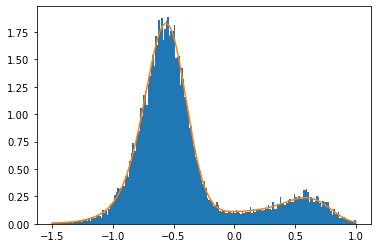

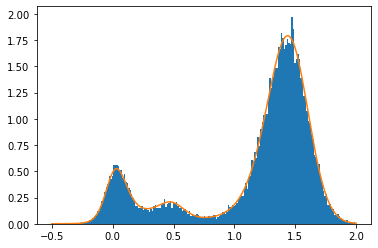

In [107]:
x_record = np.array(x_record)
xp = x_record[:, 9, :]

x1, x2 = xp[:,0], xp[:,1]

def p_x_9(x):
    p_x = integrate.quad(lambda y: p_x_y(x, y), -0.5, 2)
    return p_x

def p_y_9(y):
    p_y = integrate.quad(lambda x: p_x_y(x, y), -1.5, 1)
    return p_y

plt.hist(x1, density=True, bins = 200)
lines = np.linspace(-1.5, 1, 1000)
x1_curve = [p_x_9(l)[0] for l in lines]
plt.plot(lines, x1_curve)
plt.show()

plt.hist(x2, density=True, bins = 200)
lines = np.linspace(-0.5, 2.0, 1000)
x2_curve = [p_y_9(l)[0] for l in lines]
plt.plot(lines, x2_curve)
plt.show()

In [98]:
print(alphas)

tensor([0.0010, 0.0064, 0.0119, 0.0173, 0.0228, 0.0282, 0.0337, 0.0391, 0.0446,
        0.0500])


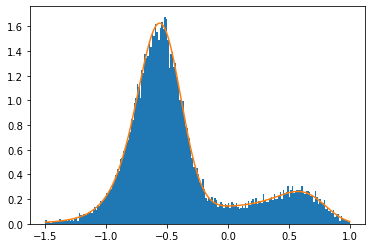

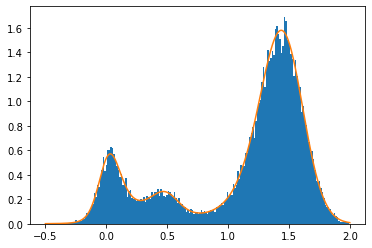

In [111]:
x_record = np.array(x_record)
xp = x_record[:, 8, :]

x1, x2 = xp[:,0], xp[:,1]

def p_x_8(x):
    p_x = integrate.quad(lambda y: p_x_y(x, y, beta = float(alphas[8])), -0.5, 2)
    return p_x

def p_y_8(y):
    p_y = integrate.quad(lambda x: p_x_y(x, y, beta = float(alphas[8])), -1.5, 1)
    return p_y

plt.hist(x1, density=True, bins = 200)
lines = np.linspace(-1.5, 1, 1000)
x1_curve = [p_x_8(l)[0] for l in lines]
plt.plot(lines, x1_curve)
plt.show()

plt.hist(x2, density=True, bins = 200)
lines = np.linspace(-0.5, 2.0, 1000)
x2_curve = [p_y_8(l)[0] for l in lines]
plt.plot(lines, x2_curve)
plt.show()

## Comparison of PDF for $\beta = 0.05$ and $\beta = 0.0446$

In [131]:
betas = alphas
pdf_dict = dict()

for beta in betas:
    beta = float(beta)
    def p_x_given_beta(x):
        p_x = integrate.quad(lambda y: p_x_y(x, y, beta), -0.5, 2)
        return p_x
    pdf_dict[beta] = p_x_given_beta

### $x_1$ Comparison

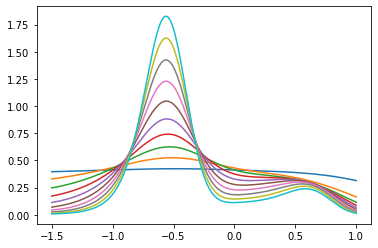

In [141]:
xaxis = np.linspace(-1.5, 1, 1000)

for beta in betas:
    f = pdf_dict[float(beta)]
    curve = [f(x)[0] for x in xaxis]
    plt.plot(xaxis, curve)

plt.show()

## Save Data

In [142]:
with open('samples_beta_%.3f.pkl'%beta, 'wb') as file_handle:
    pickle.dump({'beta_lst': betas, 'x_record': x_record}, file_handle)

## Generate Seperate Datasets Using in A and B

### Region A

In [10]:
Abounds = [[-1.5, 0], [0.55, 2]]
alpha = 0.05

x1_min, x1_max = -1.5, 0
x2_min, x2_max = 0.55, 2

num_reps = 10
alphas = torch.linspace(0.001, alpha, num_reps)

num_steps = 320000
x_record = []
accept_rate = 0
x = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),
                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),
                dim = -1)
                
energy = compute_Muller_potential(1.0, x)

for k in range(num_steps):
    if (k + 1) % 50000 == 0:
        print("idx of steps: {}".format(k))
        
    ## sampling within each replica
    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.5
    x_p = x + delta_x
    energy_p = compute_Muller_potential(1.0, x_p)

    ## accept based on energy
    accept_prop = torch.exp(-alphas*(energy_p - energy))
    accept_flag = torch.rand(num_reps) < accept_prop

    ## considering the bounding effects
    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1) \
                              & torch.all(x_p < x_p.new_tensor([x1_max, x2_max]), -1)
    
    x_p[~accept_flag] = x[~accept_flag]
    energy_p[~accept_flag] = energy[~accept_flag]    
    x = x_p
    energy = energy_p

    ## calculate overall accept rate
    accept_rate = accept_rate + (accept_flag.float() - accept_rate)/(k+1)    
    
    ## exchange
    if k % 10 == 0:
        x_ori = x
        for i in range(1, num_reps):
            accept_prop = torch.exp((alphas[i] - alphas[i-1])*(energy[i] - energy[i-1]))
            accept_flag = torch.rand(1) < accept_prop
            if accept_flag.item(): 
                tmp = x[i].clone() 
                x[i] = x[i-1].clone()
                x[i-1] = tmp.clone() #im not sure if the third clone is nessesary

                tmp = energy[i].clone()
                energy[i] = energy[i-1].clone()
                energy[i-1] = tmp.clone()
                
        if k >= 20000:
            x_record.append(x.clone().numpy())
        
x_record_A = np.array(x_record)

idx of steps: 49999
idx of steps: 99999
idx of steps: 149999
idx of steps: 199999
idx of steps: 249999
idx of steps: 299999


In [11]:
with open('Asamples_beta_%.3f.pkl'%beta, 'wb') as file_handle:
    pickle.dump({'beta_lst': alphas, 'x_record': x_record_A}, file_handle)

### Region B

In [12]:
Bbounds = [[-0.8, 1], [-0.5, 0.8]] 
alpha = 0.05

x1_min, x1_max = -0.8, 1
x2_min, x2_max = -0.5, 0.8

num_reps = 10
alphas = torch.linspace(0.001, alpha, num_reps)

num_steps = 320000
x_record = []
accept_rate = 0
x = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),
                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),
                dim = -1)
                
energy = compute_Muller_potential(1.0, x)

for k in range(num_steps):
    if (k + 1) % 50000 == 0:
        print("idx of steps: {}".format(k))
        
    ## sampling within each replica
    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.5
    x_p = x + delta_x
    energy_p = compute_Muller_potential(1.0, x_p)

    ## accept based on energy
    accept_prop = torch.exp(-alphas*(energy_p - energy))
    accept_flag = torch.rand(num_reps) < accept_prop

    ## considering the bounding effects
    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1) \
                              & torch.all(x_p < x_p.new_tensor([x1_max, x2_max]), -1)
    
    x_p[~accept_flag] = x[~accept_flag]
    energy_p[~accept_flag] = energy[~accept_flag]    
    x = x_p
    energy = energy_p

    ## calculate overall accept rate
    accept_rate = accept_rate + (accept_flag.float() - accept_rate)/(k+1)    
    
    ## exchange
    if k % 10 == 0:
        x_ori = x
        for i in range(1, num_reps):
            accept_prop = torch.exp((alphas[i] - alphas[i-1])*(energy[i] - energy[i-1]))
            accept_flag = torch.rand(1) < accept_prop
            if accept_flag.item(): 
                tmp = x[i].clone() 
                x[i] = x[i-1].clone()
                x[i-1] = tmp.clone() #im not sure if the third clone is nessesary

                tmp = energy[i].clone()
                energy[i] = energy[i-1].clone()
                energy[i-1] = tmp.clone()
                
        if k >= 20000:
            x_record.append(x.clone().numpy())
        
x_record_B = np.array(x_record)

idx of steps: 49999
idx of steps: 99999
idx of steps: 149999
idx of steps: 199999
idx of steps: 249999
idx of steps: 299999


In [13]:
with open('Bsamples_beta_%.3f.pkl'%beta, 'wb') as file_handle:
    pickle.dump({'beta_lst': alphas, 'x_record': x_record_B}, file_handle)